# 双目视觉标定与三维重建
学号：23103402  
姓名：丁悦林

In [81]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [82]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 棋盘格场景下绘制极线对比

### 准备数据

In [99]:
def get_data(left_img_dir, right_img_dir, shape, size):
    """
    加载左右相机的棋盘格图像，提取角点坐标数据
    """
    left_img_paths = sorted(glob.glob(os.path.join(left_img_dir, '*.png')))
    right_img_paths = sorted(glob.glob(os.path.join(right_img_dir, '*.png')))
    if not left_img_paths or not right_img_paths:
        raise FileNotFoundError(f'加载图像出错')
    if len(left_img_paths) != len(right_img_paths):
        raise ValueError('左右相机图像数量不一致')

    w,h = shape
    # cp:corner points
    cp_int = np.zeros((w*h, 3), np.float32)
    cp_int[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)
    cp_world = cp_int * size # (w*h,3):每一行为(X,Y,Z)

    points_world = [] # 世界坐标
    left_points_pixel = [] # 像素坐标
    right_points_pixel = []
    img_size = None

    for idx, (left_path,right_path) in enumerate(zip(left_img_paths, right_img_paths)):
        left_img = cv2.imread(left_path)
        right_img = cv2.imread(right_path)
        if left_img is None or right_img is None:
            print(f'第{idx+1}对图像读取失败')
            continue

        left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
        right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

        if img_size is None:
            img_size = left_gray.shape[::-1]
        
        # 检测左右图像角点
        ret_left, cp_left = cv2.findChessboardCorners(left_gray, (w, h), None)
        ret_right, cp_right = cv2.findChessboardCorners(right_gray, (w, h), None)

        if ret_left and ret_right:
            # 亚像素角点精细化
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            cp_left = cv2.cornerSubPix(left_gray, cp_left, (11, 11), (-1, -1), criteria)
            cp_right = cv2.cornerSubPix(right_gray, cp_right, (11, 11), (-1, -1), criteria)

            points_world.append(cp_world)
            left_points_pixel.append(cp_left)
            right_points_pixel.append(cp_right)
        else:
            print(f'第{idx}对图像角点检测失败')

    return points_world, left_points_pixel, right_points_pixel, img_size, left_img_paths, right_img_paths


In [100]:
left_img_dir = "../data/imgs/leftcamera"
right_img_dir = "../data/imgs/rightcamera"
shape = (11,7)
size = 0.025

In [101]:
points_world, left_points_pixel, right_points_pixel, img_size, left_img_paths, right_img_paths = get_data(
    left_img_dir, right_img_dir, shape, size
)

### 单目标定

In [102]:
left_ret, left_K, left_D, left_r, left_t = cv2.calibrateCamera(
    points_world, left_points_pixel, img_size, None, None
)
right_ret, right_K, right_D, right_r, right_t = cv2.calibrateCamera(
    points_world, right_points_pixel, img_size, None, None
)

print("单目标定：")
print(f'左相机重投影误差:{left_ret:.8f}像素')
print(f'右相机重投影误差:{right_ret:.8f}像素')

单目标定：
左相机重投影误差:0.18599398像素
右相机重投影误差:0.19946862像素


### 对比实验

In [103]:
criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6)
flags1 = cv2.CALIB_FIX_INTRINSIC # 完全固定输入的内参和畸变系数

ret1, left_K1, left_D1, right_K1, right_D1, R1, T1, E1, F1 = cv2.stereoCalibrate(
        points_world, left_points_pixel, right_points_pixel,
        left_K, left_D,
        right_K, right_D,
        img_size,
        criteria=criteria_stereo,
        flags=flags1
    )

print(f'固定内参的重投影误差:{ret1:.8f}像素')
print(f"固定内参标定得到的基本矩阵F1：\n{F1}")

固定内参的重投影误差:0.20520025像素
固定内参标定得到的基本矩阵F1：
[[ 4.12390397e-08  1.50066068e-06  6.42674055e-04]
 [ 8.78947354e-07  1.77063459e-06  4.76632998e-02]
 [-9.79328426e-04 -5.01026891e-02  1.00000000e+00]]


In [104]:
flags2 = 0 # 不依赖输入系数，重新计算

ret2, left_K2, left_D2, right_K2, right_D2, R2, T2, E2, F2 = cv2.stereoCalibrate(
        points_world, left_points_pixel, right_points_pixel,
        None, None,
        None, None,
        img_size,
        criteria=criteria_stereo,
        flags=flags2
    )

print(f'不带内参的重投影误差:{ret2:.8f}像素')
print(f"不带内参标定得到的基本矩阵F2：\n{F2}")

不带内参的重投影误差:0.20327006像素
不带内参标定得到的基本矩阵F2：
[[ 6.03165541e-08  1.77029008e-07  1.18432983e-03]
 [ 2.51281836e-06  2.00114906e-06  5.26935166e-02]
 [-1.55460277e-03 -5.50779216e-02  1.00000000e+00]]


In [105]:
print(np.allclose(F1, F2))

False


两种方式求解得到的基本矩阵F1、F2不同，误差re1、ret2也不同。并且明显感受到不带内参进行双目标定的代码运行时间更长。

不带内参计算比固定内参得到的误差略小，说明全局计算结果F2优于分步计算结果F1。  
但是两种方式得到的误差相差不大，说明数据质量较高。

In [106]:
flags3 = cv2.CALIB_USE_INTRINSIC_GUESS # 使用输入的内参和畸变系数作为优化的初值

ret3, left_K3, left_D3, right_K3, right_D3, R3, T3, E3, F3 = cv2.stereoCalibrate(
        points_world, left_points_pixel, right_points_pixel,
        left_K, left_D,
        right_K, right_D,
        img_size,
        criteria=criteria_stereo,
        flags=flags3
    )

print(f'使用内参初值进一步优化，重投影误差:{ret3:.8f}像素')
print(f"使用内参初值进一步优化，标定得到的基本矩阵：\n{F3}")

使用内参初值进一步优化，重投影误差:0.20327006像素
使用内参初值进一步优化，标定得到的基本矩阵：
[[ 6.03165541e-08  1.77029008e-07  1.18432983e-03]
 [ 2.51281836e-06  2.00114906e-06  5.26935166e-02]
 [-1.55460277e-03 -5.50779216e-02  1.00000000e+00]]


In [107]:
print(np.allclose(F3, F2))

True


其实还有另外一种双目标定的flags：`cv2.CALIB_USE_INTRINSIC_GUESS`，使用输入的内参和畸变系数作为优化的初值。  
这种双目标定的方式得到的结果F3与F2相同。

### 绘制极线

In [137]:
def draw_line(left_img, right_img, fundamental_matrix, shape):
    """
    在左图角点的基础上计算并绘制右图极线
    """
    if left_img is None or right_img is None:
        raise ValueError('输入图像为空，无法绘制极线')

    w,h = shape
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    # 在左图上找角点
    ret_left, left_corners = cv2.findChessboardCorners(left_gray, (w, h), None)
    if not ret_left:
        raise ValueError('左图角点检测失败')
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    left_corners = cv2.cornerSubPix(left_gray, left_corners, (11, 11), (-1, -1), criteria)

    # 计算左图角点对应的极线
    lines_right = cv2.computeCorrespondEpilines(left_corners.reshape(-1, 1, 2), 1, fundamental_matrix)
    lines_right = lines_right.reshape(-1, 3) # (a,b,c) ax+by+c=0

    # 在右图上绘制极线
    right_result = right_img.copy()
    h_img, w_img = right_result.shape[:2]
    np.random.seed(0)

    for line in lines_right: # 数学计算
        a, b, c = line
        if abs(b) < 1e-6:
            y0, y1 = 0, h_img - 1
            x0 = x1 = int(round(-c / a)) if abs(a) > 1e-6 else 0
        else:
            y0 = int(round(-c / b))
            y1 = int(round(-(c + a * (w_img - 1)) / b))
            x0, x1 = 0, w_img - 1
        color = tuple(int(v) for v in np.random.randint(0, 255, 3))
        cv2.line(right_result, (x0, y0), (x1, y1), color, 1)

    # 在右图上绘制真实的角点，视觉验证
    ret_right, right_corners = cv2.findChessboardCorners(right_gray, (w, h), None)
    if ret_right:
        right_corners = cv2.cornerSubPix(right_gray, right_corners, (11, 11), (-1, -1), criteria)
        for corner in right_corners:
            point = tuple(corner[0].astype(int))
            cv2.circle(right_result, point, 3, (0, 255, 0), -1)

    return right_result


In [120]:
# 取第一张图像绘制
img_l = cv2.imread(left_img_paths[0])
img_r = cv2.imread(right_img_paths[0])

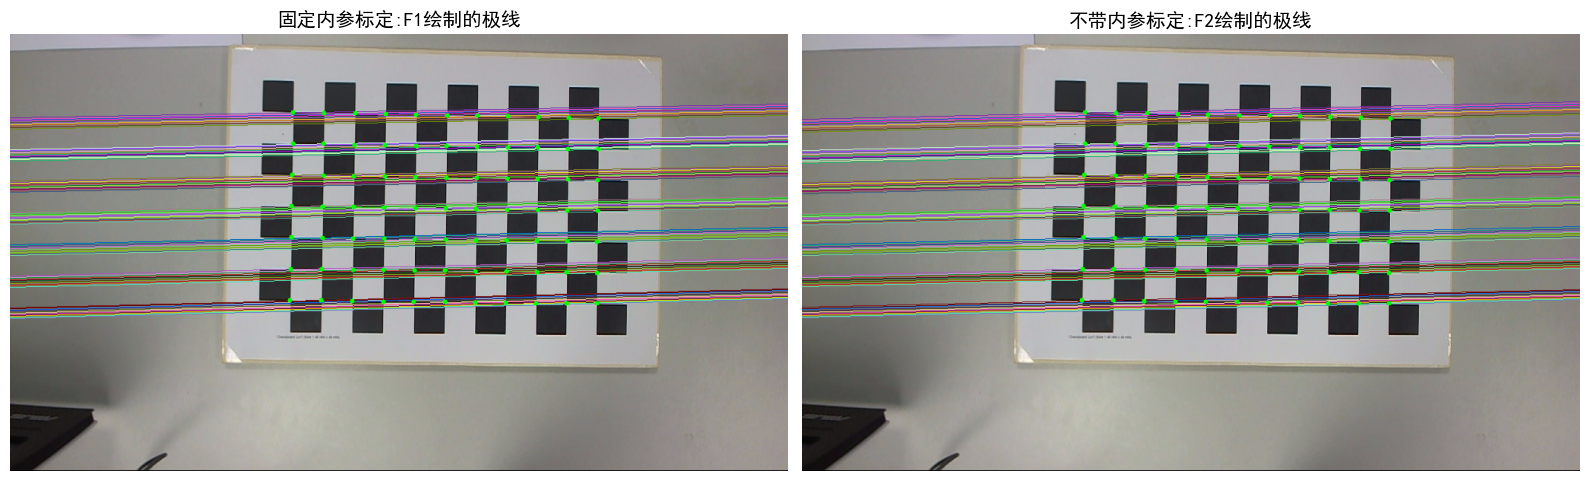

In [138]:
right_with_lines_F1 = draw_line(img_l, img_r, F1, shape)
right_with_lines_F2 = draw_line(img_l, img_r, F2, shape)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(cv2.cvtColor(right_with_lines_F1, cv2.COLOR_BGR2RGB))
axes[0].set_title('固定内参标定:F1绘制的极线', fontsize=14)
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(right_with_lines_F2, cv2.COLOR_BGR2RGB))
axes[1].set_title('不带内参标定:F2绘制的极线', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

绘制极线只需要基础矩阵F。  
两种双目标定方式计算得到的F值不同，理论上F2绘制出极线的精度应该是更优的，但是视觉上肉眼很难观察到。

## 街景场景下三维重建

本实验采用KITTI Odometry Benchmark(Geiger et al., 2012)Sequence 00的典型标定参数进行三维重建

### 准备

In [150]:
# KITTI Odometry Benchmark Sequence 00

# 焦距（像素）
f = 718.8560

# 基线（米）
B = 0.5379

# 图像的光心坐标（像素）
cx = 607.1928
cy = 185.2157

# 构建重投影矩阵 Q
# Q 矩阵定义了从 (u, v, d) 到 (X, Y, Z) 的映射关系
# 这里的 1/B 前面的负号取决于视差计算方向
# 如果使用的是 OpenCV StereoBM/SGBM (左图-右图)，通常取负号
Q = np.float32([
    [1, 0, 0, -cx],
    [0, 1, 0, -cy],
    [0, 0, 0, f],
    [0, 0, -1/B, 0]
])

print(f"焦距f = {f}")
print(f"基线B = {B}")
print("Q矩阵:\n", Q)

焦距f = 718.856
基线B = 0.5379
Q矩阵:
 [[   1.           0.           0.        -607.1928   ]
 [   0.           1.           0.        -185.2157   ]
 [   0.           0.           0.         718.856    ]
 [   0.           0.          -1.8590816    0.       ]]


In [200]:
L_img = cv2.imread("../data/L.png")
R_img = cv2.imread("../data/R.png")
L_img_gray = cv2.cvtColor(L_img, cv2.COLOR_BGR2GRAY)
R_img_gray = cv2.cvtColor(R_img, cv2.COLOR_BGR2GRAY)

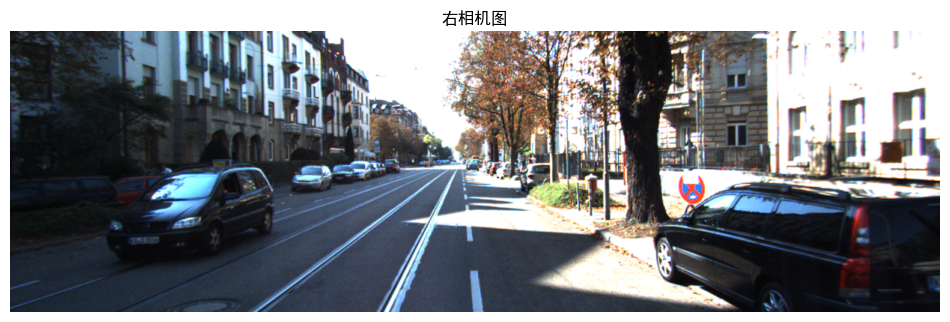

In [201]:
plt.figure(figsize=(12, 5))
plt.imshow(cv2.cvtColor(R_img, cv2.COLOR_BGR2RGB))
plt.title('右相机图')
plt.axis('off')
plt.show()

### 视差图

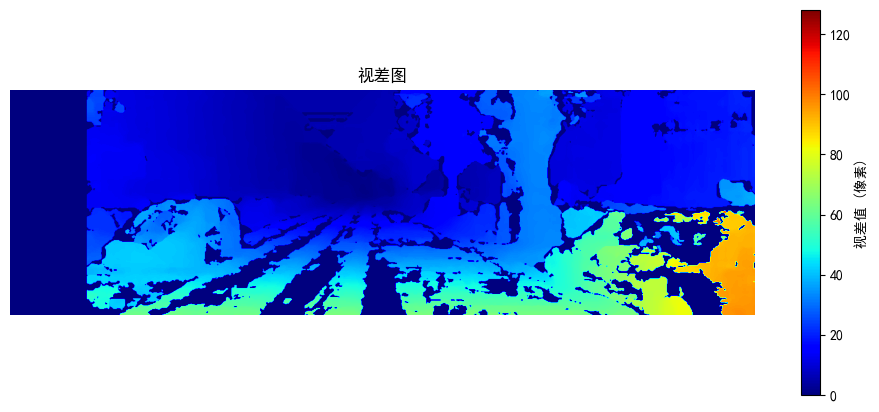

In [ ]:
min_disp = 0
num_disp = 16 * 8  # 128，够用了
block_size = 11    # 改到 11，路面纹理才能被抓住

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    # P1 P2 随 block_size 自动变大
    P1=8 * 3 * block_size**2,
    P2=32 * 3 * block_size**2,
    
    # 改到 20 或 32，填补由于误差导致的空洞
    disp12MaxDiff=32, 
    
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
)

disparity = stereo.compute(L_img_gray, R_img_gray).astype(np.float32) / 16.0
# 把无效值强制设为 min_disp (0)，这样它们在图中就是深蓝/黑色
disparity[disparity <= 0] = min_disp

plt.figure(figsize=(12, 5))
# 使用 jet 并锁定显示范围
plt.imshow(disparity, cmap='jet', vmin=0, vmax=num_disp)
plt.colorbar(label='视差值 (像素)')
plt.title('视差图')
plt.axis('off')
plt.show()

### 深度图

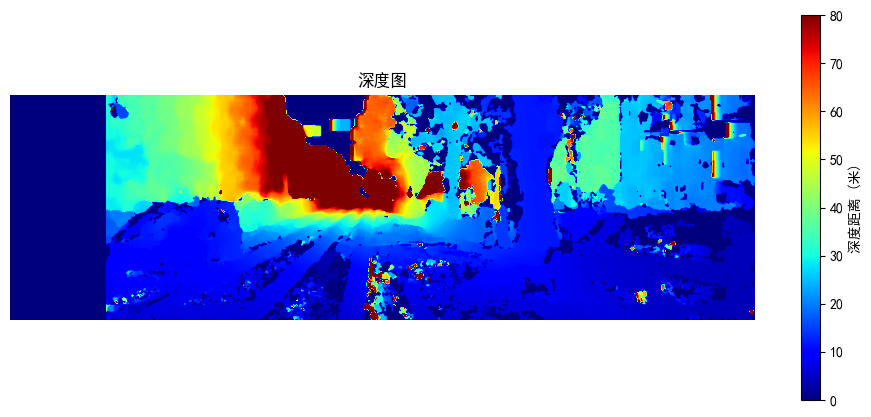

In [209]:
# 2. 计算深度图
# 复制一份视差图，防止修改原数据
depth_map = np.zeros_like(disparity)

# 避免除以 0 的错误：
# 建立一个掩膜(mask)，只处理视差值大于 0.1 的点
mask = disparity > 0.1

# 仅对有效像素应用公式 Z = f * B / d
depth_map[mask] = (f * B) / disparity[mask]

# 3. 可视化绘制
plt.figure(figsize=(12, 5))

# --- 关键设置 ---
# vmax=80: KITTI 激光雷达的有效距离大约是 80-100米。
# 我们把显示范围限制在 [0, 80] 米。
# 如果不限制，天空的视差极小，深度会计算成几千米，导致近处的车和路全都黑成一片看不清。
plt.imshow(depth_map, cmap='jet', vmin=0, vmax=80)

plt.colorbar(label='深度距离 (米)')
plt.title('深度图') # 颜色越暖代表距离越远
plt.axis('off')
plt.show()